# Patterns Mining & Association Rules, is clustering improving?
Mining frequent patterns and association rules over the [House prices dataset (Kaggle)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) <br> 



### 0. Imports

In [22]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning library
import sklearn

#Patterns Mining
from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")
import utils


##### Loading the CSV dataset

In [23]:
dataset_path = "./datasets/titanic.csv"
dtf = pd.read_csv(dataset_path,index_col='PassengerId')
dtf[:1]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [24]:
#check if any column is null
dtf.isnull().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

In [25]:
dtf.dtypes


Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

#### Drop possibly problematic columns

In [26]:
## Date and Note are date and text which we cant really use
dtf = dtf.drop(columns=['Name', 'Ticket'])

##### Defining numeric and categorical columns

In [27]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]
ordinals = list(set(numeric_columns) - set(very_numerical))

##### Filling Null Values with the column's mean

In [28]:
na_columns = dtf[very_numerical].isna().sum()
na_columns = na_columns[na_columns>0]
for nc in na_columns.index:
    dtf[nc].fillna(dtf[nc].mean(),inplace=True)

##### Dropping and filling NA values for categorical columns:

1. drop if at least 70% are NA:

In [29]:
nul_cols = dtf[categorical_columns].isna().sum()/len(dtf)
drop_us = nul_cols[nul_cols>0.7]

In [30]:
dtf=dtf.drop(drop_us.index,axis=1)
categorical_columns = list(set(categorical_columns)-set(drop_us.index))

2. Fill with a new 'na' category:

In [31]:
dtf[categorical_columns]= dtf[categorical_columns].fillna('na')

##### one hot encoding/lable encoding Categorical data for clustreing

In [32]:
dtf_encoded = utils.label_encoding(dtf.copy(), categorical_columns)
dtf_encoded.dtypes

Survived      int64
Pclass        int64
Sex           int32
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int32
dtype: object

#### Find best k

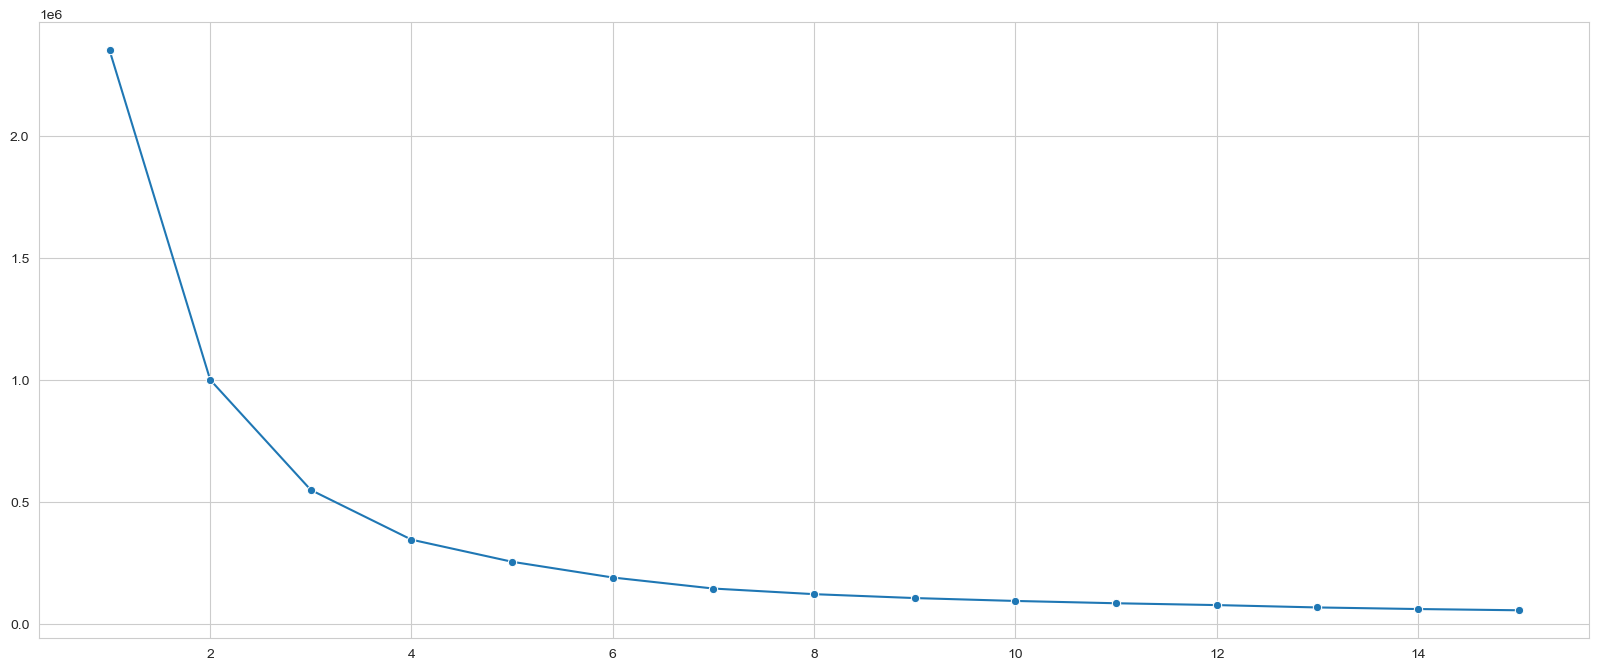

In [33]:
utils.opt_kmeans(dtf_encoded,15)

In [34]:
clusters = utils.run_k_means(5,dtf_encoded,dtf)
lens = [len(a) for a in clusters.values()]
lens

[33, 126, 712, 3, 17]

##### removing small clusters

In [35]:
labels2remove = []
for label,cdf in clusters.items():
    print(len(cdf))

    #removing clusters under 1% in size. this is just so we dont get things with very high relative support
    if len(cdf) < len(dtf)/100:
        labels2remove.append(label)
for label in labels2remove:
    del clusters[label]
len(clusters)


33
126
712
3
17


4

### 2. Using Apriori on a each cluster:

### Preprocessing clusters for apriori

In [36]:
clusters[list(clusters.keys())[0]][:1]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
32,1,1,female,29.699118,1,0,146.5208,C


In [37]:
for label,cdf in clusters.items():
    clusters[label] = utils.preprocess_4_apriori(cdf,very_numerical)
clusters[list(clusters.keys())[0]]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
32,1,1,female,low,1,0,high,C
196,1,1,female,very high,0,0,high,C
216,1,1,female,medium,1,0,low,C
269,1,1,female,very high,0,1,very high,S
270,1,1,female,medium,0,0,medium,S
298,0,1,female,very low,1,2,high,S
306,1,1,male,very low,1,2,high,S
307,1,1,female,low,0,0,very low,C
308,1,1,female,very low,1,0,very low,C


In [38]:
clusters[list(clusters.keys())[0]][:1]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
32,1,1,female,low,1,0,high,C


In [46]:
#might need to select only several columns for running effiency
patitioned_total_rules = set()

for label,cdf in clusters.items():
    transactions = utils.convert_ds_to_transactions(cdf)
    itemsets, rules = apriori(transactions, min_support=0.5, min_confidence=0.8,output_transaction_ids=False)
    print(len(patitioned_total_rules))
    patitioned_total_rules.update(rules)

patitioned_total_rules=list(patitioned_total_rules)
len(patitioned_total_rules)

0
12
12
26


27

### do apriori on the initial dataset for comparison

In [47]:
transactions = utils.convert_ds_to_transactions(dtf)
unpatitioned_total_itemsets, unpatitioned_total_rules = apriori(transactions, min_support=0.5, min_confidence=0.8,output_transaction_ids=False)
#print(rules)  # [{eggs} -> {bacon}, {soup} -> {bacon}]

In [48]:
len(unpatitioned_total_rules)

4

## 2. Analyzing the rules:
We need a measures of interestingness to evaluate our results.

We first use the Lift measurement taught in class.
on top of that we use the Conviction and Leverage measurements.
formulas and meaning of those can be seen in the report file.

### Lift comparison

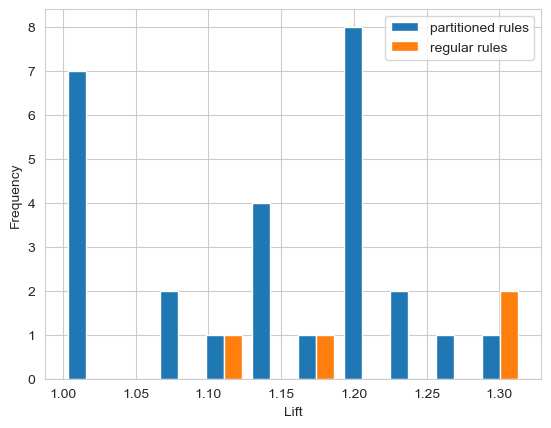

In [49]:
partitioned_lift_arr = [rule.lift for rule in patitioned_total_rules]
unpartitioned_lift_arr = [rule.lift for rule in unpatitioned_total_rules]
plt.hist([partitioned_lift_arr,unpartitioned_lift_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Lift')
plt.ylabel('Frequency')

plt.show()


### Conviction comparison

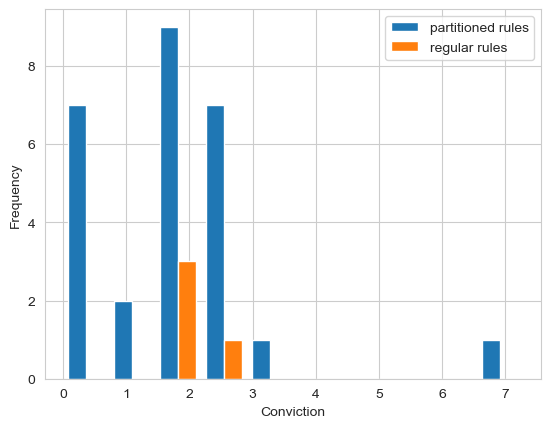

In [50]:
#creating conviction graph for both the partitioned rules and the unpartitioned rules
partitioned_conviction_arr = [rule.conviction for rule in patitioned_total_rules]
unpartitioned_conviction_arr = [rule.conviction for rule in unpatitioned_total_rules]
plt.hist([partitioned_conviction_arr,unpartitioned_conviction_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Conviction')
plt.ylabel('Frequency')

plt.show()

### Confidence comparison


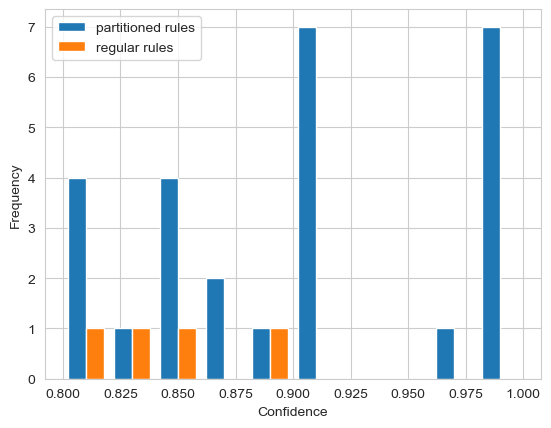

In [51]:
partitioned_conf_arr = [rule.confidence for rule in patitioned_total_rules]
unpartitioned_conf_arr = [rule.confidence for rule in unpatitioned_total_rules]
plt.hist([partitioned_conf_arr,unpartitioned_conf_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.show()

###Leverage comprasion